In [17]:
import numpy as np
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px

# Setup paths
src_path = os.path.abspath(os.path.join('..'))
sys.path.append(src_path)
from utilities import clean_data
data_folder = os.path.join(src_path, 'data')

# Load and clean data
df = pd.read_csv(f'{data_folder}/MMR_DATA.csv')
df = clean_data(df)

# Generate embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
X = df['Map Data'].to_numpy()
embeddings_list = model.encode(X.tolist(), show_progress_bar=True)
df_embeddings = pd.DataFrame(embeddings_list)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

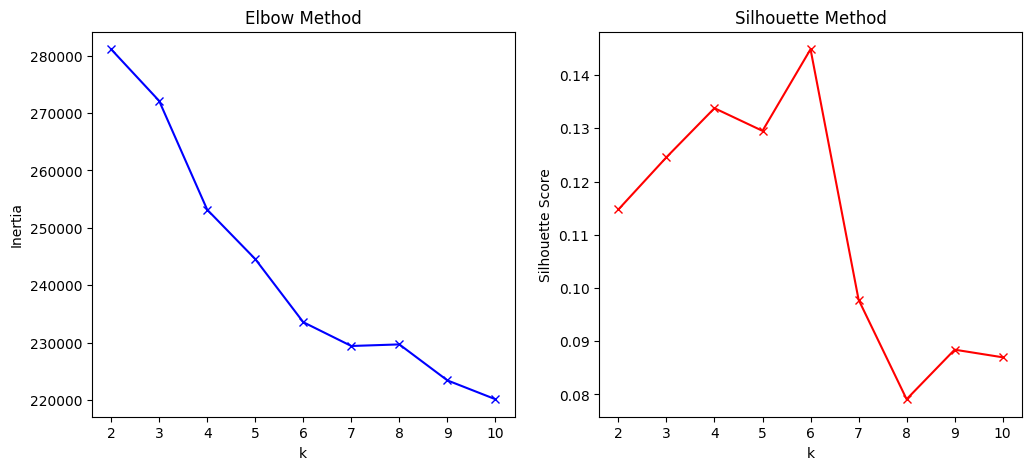

KMeans(n_clusters=6, random_state=42)

In [18]:

# Create final dataset
df_final = pd.concat([df, df_embeddings], axis=1)
df_final.to_csv(f'{data_folder}/MMR_DATA_ST_EMBEDDINGS.csv', index=False)
df_embeddings.to_csv(f'{data_folder}/MMR_DATA_ST_EMBEDDINGS_ONLY.csv', index=False)

# Clustering
df_embeddings_np = df_embeddings.to_numpy()
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(df_embeddings_np)

# Find optimal k using elbow method
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_embeddings, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

# Choose optimal k from elbow point
from kneed import KneeLocator
kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = kn.knee

# Use optimal k for clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_embeddings)

In [16]:
# TSNE visualization
strings = df_final['Map Data'].to_numpy()
tsne = TSNE(n_components=3, random_state=42, verbose=2, perplexity=55, n_iter=2500)
x_3d = tsne.fit_transform(scaled_embeddings)

df = pd.DataFrame({
    'x': x_3d[:, 0],
    'y': x_3d[:, 1],
    'z': x_3d[:, 2],
    'label': y_kmeans[:x_3d.shape[0]] + 1,
    'strings': strings[:x_3d.shape[0]]
})
# Plot
color_sequence = px.colors.qualitative.Plotly
fig = px.scatter_3d(df, x='x', y='y', z='z', 
                    color='label', 
                    color_discrete_sequence=color_sequence,
                    hover_data={'strings': True})
fig.show()

[t-SNE] Computing 166 nearest neighbors...
[t-SNE] Indexed 814 samples in 0.002s...
[t-SNE] Computed neighbors for 814 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 814 / 814
[t-SNE] Mean sigma: 7.179116
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 58.8784256, gradient norm = 0.0000002 (50 iterations in 0.820s)
[t-SNE] Iteration 100: error = 58.8781815, gradient norm = 0.0000000 (50 iterations in 0.588s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 58.878181
[t-SNE] Iteration 150: error = 1.0844166, gradient norm = 0.0182050 (50 iterations in 0.417s)
[t-SNE] Iteration 200: error = 0.8408675, gradient norm = 0.0079184 (50 iterations in 0.647s)
[t-SNE] Iteration 250: error = 0.7848504, gradient norm = 0.0091884 (50 iterations in 0.425s)
[t-SNE] Iteration 300: error = 0.7527097, gradient norm = 0.0080308 (50 iterations in 0.363s)
[t-SNE] Iterat

In [ ]:
# Auto-labeling function
def autogenerate_labels(df):
    map_data = df['Map Data'].to_numpy()
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_list = model.encode(map_data.tolist(), show_progress_bar=True)
    
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings_list)
    
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_embeddings)
    
    df['label'] = kmeans.labels_ + 1
    return df

# Test auto-labeling
df = pd.read_csv(f'{data_folder}/MMR_DATA.csv')
df = clean_data(df)
df = autogenerate_labels(df)